<a href="https://colab.research.google.com/github/jimmyliao/HorusEye/blob/function_modify/HorusEye_tw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 版權所有 2024 Google LLC
#
# 根據 Apache 授權許可，版本 2.0（「許可」）授權使用此檔案；
# 除符合許可條款外，您不得使用此檔案。
# 您可以在以下網址取得許可副本：
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# 除非適用法律規定或以書面形式同意，否則根據許可授權分發的軟體
# 均以「現状」為基礎提供，
# 不提供任何明示或暗示的保證。
# 如需有關許可權限和限制的詳細資訊，請參閱許可條款。

# 荷魯斯之眼：Vertex AI Imagen 3 的影像產生和偵測

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory 標誌"><br> 在 Colab 中執行
    </a>
  </td>   
  <td style="text-align: center">
    <a href="https://github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub 標誌"><br> 在 GitHub 上檢視
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>分享至：</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn 標誌">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky 標誌">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/53/X_logo_2023_original.svg" alt="X 標誌">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit 標誌">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/jimmyliao/HorusEye/blob/main/HorusEye_tw.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook 標誌">
</a>            


| | |
|-|-|
|作者 | [Jimmy Liao](https://github.com/jimmyliao) |
|共同作者 | [Kevin Chiu](https://github.com/kevin6449) |
|原始作者 | [Katie Nguyen](https://github.com/katiemn) |

## 概述

### Imagen 3

Vertex AI 上的 Imagen 3 將 Google 最先進的生成式 AI 功能帶給應用程式開發人員。Imagen 3 是 Google 目前品質最高的文字轉影像模型。它能夠產生細節驚人的影像。因此，開發人員在建構新一代 AI 產品時，可以擁有更多控制權，將他們的想像力轉化為高品質的視覺資產。瞭解更多關於 [Vertex AI 上的 Imagen](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview)。


在本教學課程中，您將學習如何使用 Google Gen AI Python SDK 與 Imagen 3 和 Imagen 3 Fast 模型互動，以產生展現以下特色的影像：

- 寫實場景
- 提示增強
- 呈現在影像中的文字
- 兩種模型之間的品質和延遲比較

## 開始使用


### 安裝 Google Gen AI Python SDK


In [2]:
%pip install --upgrade --quiet google-genai pillow

### 驗證您的筆記本環境（僅限 Colab）

如果您在 Google Colab 上執行此筆記本，請執行以下儲存格以驗證您的環境。


In [3]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### 導入函式庫

In [4]:
from google import genai
from google.genai import types

### 設定 Google Cloud 專案資訊並建立用戶端

要開始使用 Vertex AI，您必須有一個現有的 Google Cloud 專案，並 [啟用 Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)。

瞭解更多關於 [設定專案和開發環境](https://cloud.google.com/vertex-ai/docs/start/cloud-environment)。

In [5]:
import os

PROJECT_ID = "[您的專案 ID]"  # @param {type: "string", placeholder: "[您的專案 ID]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[您的專案 ID]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

### 定義輔助函數

In [6]:
import typing

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(
    image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB 受所有 Jupyter 環境支援（例如 RGBA 目前尚未支援）
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # 調整大小以顯示較小的筆記本影像
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)

### 載入影像產生模型

Imagen 3：`imagen-3.0-generate-002`

<!-- Imagen 3 Fast：`imagen-3.0-fast-generate-001` -->

In [7]:
generation_model = "imagen-3.0-generate-002"
text_model = "gemini-2.0-flash-001"
# generation_model_fast = "imagen-3.0-fast-generate-001"

### Imagen 3 和 Imagen 3 Fast

使用 Imagen 3 時，您也可以選擇使用 Imagen 3 Fast。這兩個模型選項讓您可以根據您的使用案例選擇優化品質或延遲。

**Imagen 3：**產生具有自然光線和更高寫實度的優質影像。

**Imagen 3 Fast：**適用於產生具有更高對比度的更明亮影像。總體而言，與 Imagen 2 相比，Imagen 3 Fast 的延遲降低了 40%。

使用 Imagen 3 和 Imagen 3 Fast，您也可以將 `aspect ratio` 設定為以下任何一個：
* 1:1
* 9:16
* 16:9
* 3:4
* 4:3

### 新增影像浮水印

預設會將數位浮水印或 [SynthID](https://deepmind.google/technologies/synthid/) 新增至 Imagen 3 影像。如果您想明確地將浮水印設定為 True，您可以使用 `add_watermark` 參數來執行此動作。您也可以 [驗證浮水印影像](https://cloud.google.com/vertex-ai/generative-ai/docs/image/generate-images#watermark)。

In [8]:
def generate_image(prompt, watermark=False):
    # Since Imagen 3 model only accept english, try to translate prompt to English
    translation_user_prompt = f"將以下繁體中文翻譯成英文，只直接回應一個答案不需要確認：\n\n{prompt}"
    translation_user_prompt_response = client.models.generate_content(
        model=text_model,
        contents=translation_user_prompt,
    )
    user_prompt_en = translation_user_prompt_response.text
    # print(f"翻譯後的提示：{user_prompt_en}")

    image = client.models.generate_images(
        model=generation_model,
        prompt=user_prompt_en,
        config=types.GenerateImagesConfig(
          number_of_images=1,
          aspect_ratio="1:1",
          enhance_prompt=True,
          safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
          person_generation="DONT_ALLOW",
          add_watermark=watermark,
        )
    )

    suffix_name = "_watermark" if watermark else ""

    image.generated_images[0].image._pil_image.save(f"./generated_image{suffix_name}.png")

    # 印出增強提示
    enhanced_prompt = image.generated_images[0].enhanced_prompt
    # print(f"增強提示：{enhanced_prompt}")
    # 印出翻譯後的提示
    translation_prompt = f"將以下英文翻譯成繁體中文：\n\n{enhanced_prompt}"
    translation_response = client.models.generate_content(
        model=text_model,
        contents=translation_prompt,
    )
    print(translation_response.text)

    display_image(image.generated_images[0].image)
    return image


一棟舒適且帶有鄉村氣息的房子，有著迷人的前廊和飽經風霜的木質外牆，依偎在寧靜的景色之中。一棵雄偉的橡樹在背景中挺拔聳立，枝幹伸向一片晴朗蔚藍的天空。一隻毛茸茸的金色獵犬幼犬，正嬉戲地依偎在房子旁，沐浴在傍晚溫暖的陽光下。夕陽柔和的金光為整個場景灑上溫暖的光芒，照亮了這片田園詩般的鄉村。房子的顏色採用柔和的大地色系，搭配溫暖的棕色屋頂，而鮮豔的開花灌木叢則環繞著前門入口。整體給人一種平和寧靜的印象，是一個完美的休憩港灣，能享受放鬆和溫馨的陪伴。這幅景象捕捉了一個純粹的寧靜和溫暖的時刻。



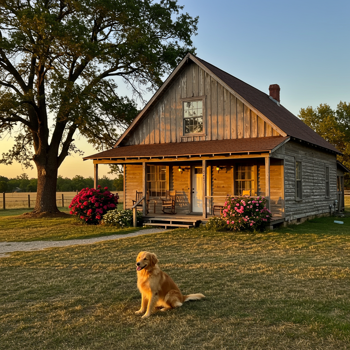

In [9]:
# 使用浮水印產生影像
# prompt_en = """
# a cozzy house with a tree in the background
# """
prompt = """
舒適的房子，背景是一棵樹，旁邊有可愛的狗趴著。
"""

image1 = generate_image(prompt, watermark=True)

一個溫馨質樸的小屋，有著迷人的前廊和飽經風霜的木質外牆，隱匿於一片寧靜的景色之中。背景中，一棵茂盛翠綠的落葉喬木佇立著，營造出祥和的氛圍。前景中，一隻毛茸茸的金毛幼犬正躺在小屋旁邊，享受著午後陽光的溫暖。小狗的眼睛半閉著，臉上洋溢著滿足的表情。鮮豔的綠色草坪和色彩繽紛的花朵為這個場景增添了一絲生機，創造出一幅如詩如畫、溫馨動人的畫面。明亮、自然的光線灑滿整個畫面，突顯了小屋溫馨而誘人的氛圍，以及周遭環境的寧靜。 這幅畫面完美地描繪了家庭的幸福和寧靜的郊區生活。



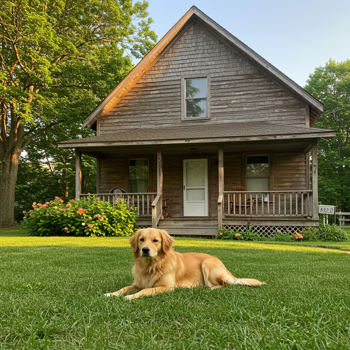

In [10]:
# 不使用浮水印產生影像
# prompt_en = """
# a cozzy house with a tree in the background
# """
prompt = """
舒適的房子，背景是一棵樹，旁邊有可愛的狗趴著。
"""

image2 = generate_image(prompt, watermark=False)

In [11]:
import vertexai
from vertexai.preview.vision_models import (
    Image,
    WatermarkVerificationModel,
)

def check_watermark(image_path):
  input_file = image_path
  vertexai.init(project=PROJECT_ID, location=LOCATION)

  verification_model = WatermarkVerificationModel.from_pretrained(
    "imageverification@001"
    )

  image = Image.load_from_file(location=input_file)

  watermark_verification_response = verification_model.verify_image(image)

  print(
      f"浮水印驗證結果：{watermark_verification_response.watermark_verification_result}"
  )

In [12]:
image1 = "./generated_image_watermark.png"
check_watermark(image1)

浮水印驗證結果：ACCEPT


In [13]:
image2 = "./generated_image.png"
check_watermark(image2)

浮水印驗證結果：REJECT
